In [1]:
from evaluation_functions import plot_performances
import time
from evaluation_functions import load_data, preprocess_corpus
from ensembliste import Ensembliste
from src.ir_evaluation import Evaluator
import numpy as np

dataset = 'cacm'
subplot = 110

In [2]:
def remove_queries_without_ground_truth(queries, ground_truth):
    new_queries = list()
    for gt in ground_truth:
        for q in queries:
            if gt['id'] == q['id']:
                new_queries.append(q)
                break
    return new_queries

def eval_ensembliste(dataset_name='med', stop_words=True, stemm=True, bag_words=True):
    """
    Evaluates performances of ensembliste SRI with a given dataset name
    Boolean parameters allows to see their impacts in the SRI performances
    :param dataset_name: str
    :param stop_words: boolean
    :param stemm: boolean
    :param bag_words: boolean
    :return: dictionary 'result'
    """
    dataset, queries, ground_truth = load_data(dataset_name)
    queries = remove_queries_without_ground_truth(queries, ground_truth)
    stop_list = np.genfromtxt('data/stoplist/stoplist-english.txt', dtype='str')
    dataset_bagwords = preprocess_corpus(dataset, stop_list, stop_words=stop_words, stemm=stemm, bag_words=bag_words)

    ground_truth_dict = dict()
    ground_truth_dict['groundtruth'] = ground_truth

    ensembliste = Ensembliste()
    result = dict()

    # Linear index
    # Compute time to build linear index
    start_linear_build = time.time()
    index_linear = ensembliste.index_construction(dataset_bagwords)
    end_linear_build = time.time()
    result["linear_build_time"] = end_linear_build - start_linear_build

    # Compute time to search in linear index
    start_search_linear = time.time()
    eval_all_queries = ensembliste.search_all_queries(queries, inverted=False, stop_words=stop_words, stemm=stemm, bag_words=bag_words)
    end_search_linear = time.time()
    result["linear_search_time"] = end_search_linear - start_search_linear

    # Evaluate performances (recall precision)
    eval_ensembliste_linear = Evaluator(retrieved=eval_all_queries, relevant=ground_truth_dict)
    result["evaluation_linear"] = eval_ensembliste_linear.evaluate_pr_points()

    # Inverted index
    # Compute time to build inverted index
    start_inverted_build = time.time()
    index_inverted = ensembliste.inverted_index_construction(dataset_bagwords)
    stop_inverted_build = time.time()
    result['inverted_build_time'] = stop_inverted_build - start_inverted_build

    # Compute time to search in inverted index
    start_search_inverted = time.time()
    eval_inverted_all_queries = ensembliste.search_all_queries(queries, inverted=True, stop_words=stop_words, stemm=stemm, bag_words=bag_words)
    end_search_inverted = time.time()
    result['inverted_search_time'] = end_search_inverted - start_search_inverted

    # Evaluate performances (recall precision)
    eval_ensembliste_inverted = Evaluator(retrieved=eval_inverted_all_queries, relevant=ground_truth_dict)
    result["evaluation_inverted"] = eval_ensembliste_inverted.evaluate_pr_points()

    return result

In [3]:
results = dict()
results["cacm"] = eval_ensembliste(dataset, stop_words=False, stemm=True, bag_words=True)

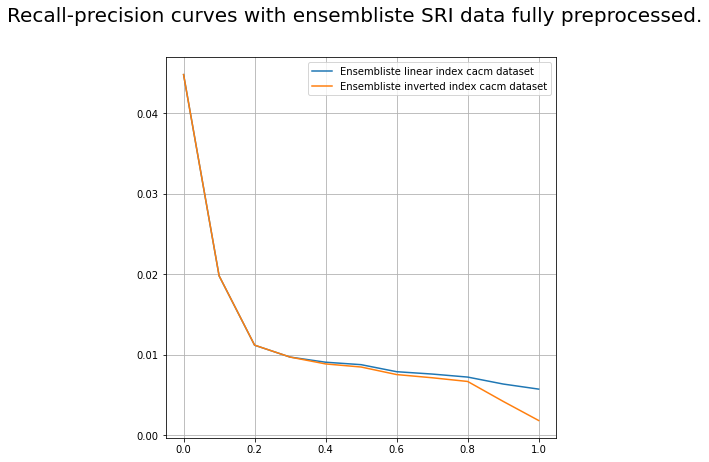

In [4]:
plot_performances(results, subplot_value=subplot, title="Recall-precision curves with ensembliste SRI data fully preprocessed.", save_plot=True, figsize=(7,7))
